In [4]:
from tensorflow.keras.utils import plot_model

In [5]:
import numpy as np
import pandas as pd

np.random.seed(0)
import random

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")


X_train = train.drop(labels = ["label"], axis = 1)
y_train = train['label']

X_test = test

print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


In [8]:
X_train_plot = X_train.values.reshape(-1, 28, 28)

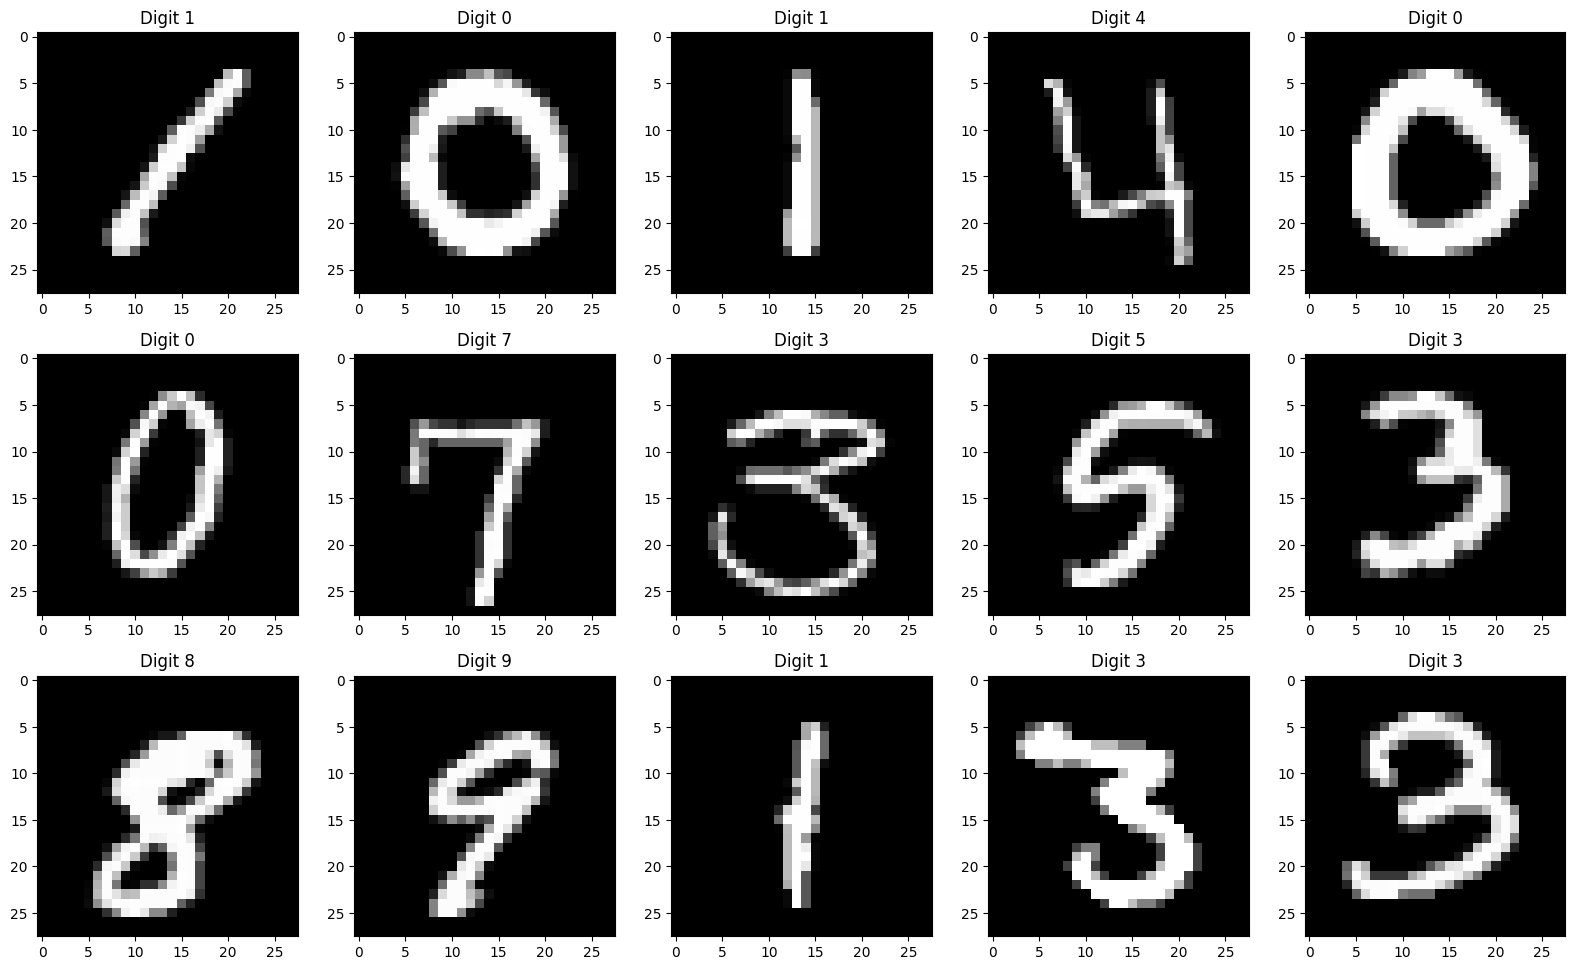

In [9]:
def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5,idx+1)
        plt.imshow(X_train_plot[idx], cmap = mono)
        plt.title("Digit {}".format(y_train[idx]))

    plt.tight_layout()

Show_example_digits()

In [10]:
# Function return digit in grayscale
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem

    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'

    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))

    plt.show()

2


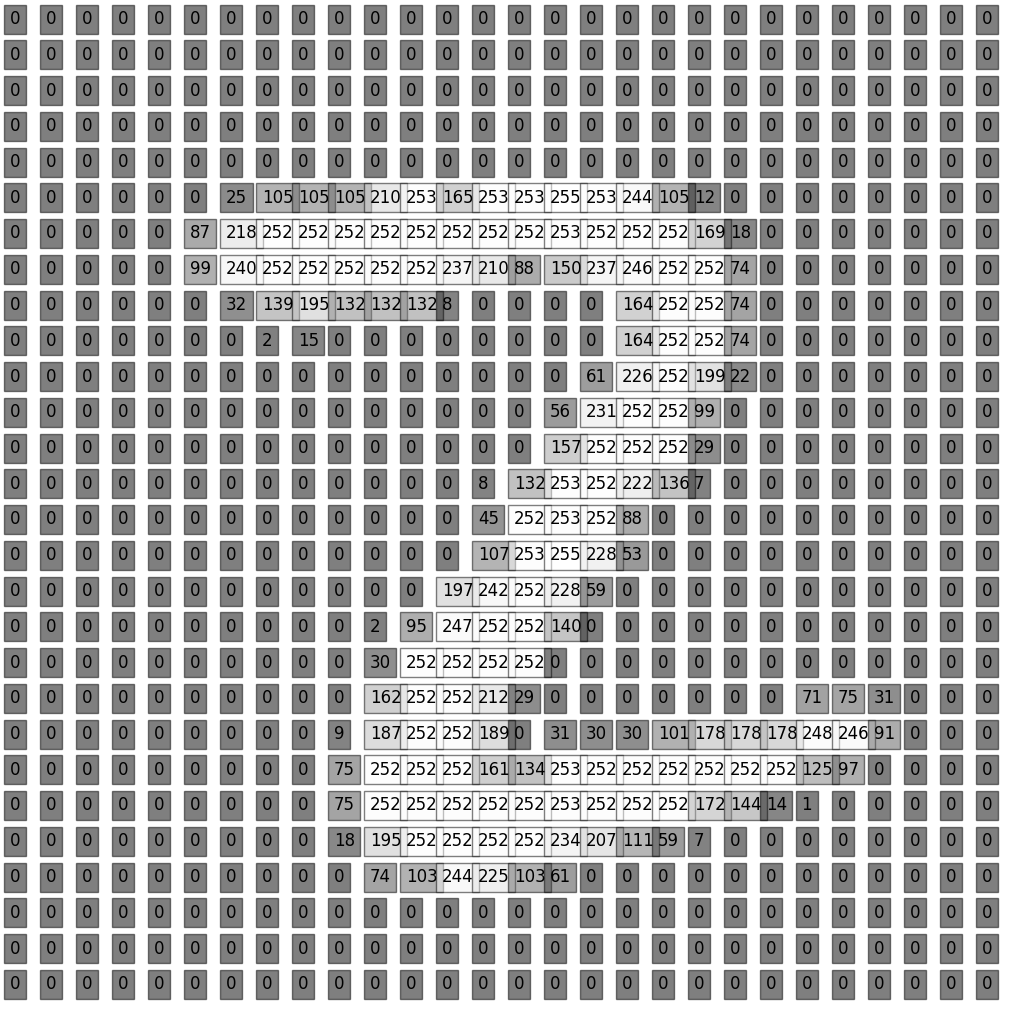

In [12]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

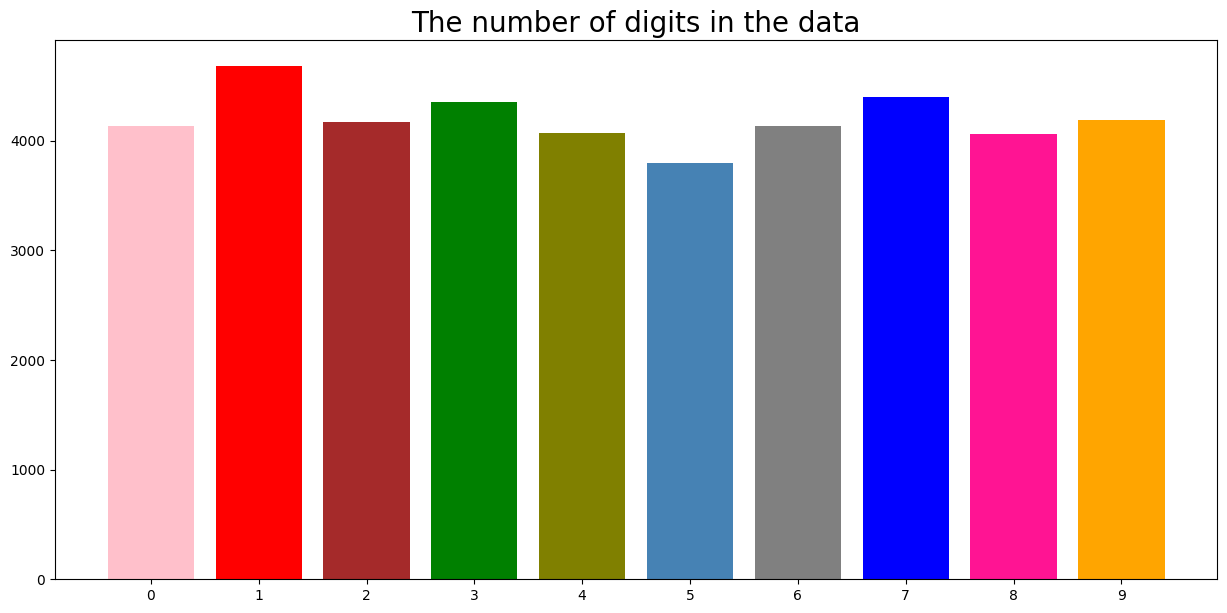

In [13]:
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

In [14]:
img_rows, img_cols = 28, 28

num_pixels = X_train.shape[1]

input_shape = (img_rows, img_cols)

In [15]:
# Data Normalization [0, 1]
X_train /= 255
X_test /= 255

# one-hot encoding for target column
y_train = to_categorical(y_train)

# | [0, 1, 2, ... , 9] | = 10
num_classes = y_train.shape[1]

# Number of objects, vector size (28 * 28)
print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2, stratify=y_train)

In [17]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [27]:
def callbacks(name):
    return [
        EarlyStopping(monitor = 'loss', patience = 6),
        ReduceLROnPlateau(monitor = 'loss', patience = 3),
        ModelCheckpoint(f'../working/{name}.keras', save_best_only=True) # saving the best model
    ]

In [28]:
def get_mlp():

    return Sequential([
        #input layer is automatic generation by keras

        #hidden layer
        Dense(512, input_dim = num_pixels, activation='relu'),

        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [29]:
model = get_mlp()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('simple_mlp'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 3s - loss: 0.6949 - f1: 0.7147 - val_loss: 0.3270 - val_f1: 0.9004 - lr: 0.0010 - 3s/epoch - 83ms/step
Epoch 2/40
37/37 - 0s - loss: 0.2702 - f1: 0.9228 - val_loss: 0.2465 - val_f1: 0.9337 - lr: 0.0010 - 373ms/epoch - 10ms/step
Epoch 3/40
37/37 - 0s - loss: 0.2104 - f1: 0.9410 - val_loss: 0.2044 - val_f1: 0.9412 - lr: 0.0010 - 362ms/epoch - 10ms/step
Epoch 4/40
37/37 - 0s - loss: 0.1738 - f1: 0.9520 - val_loss: 0.1747 - val_f1: 0.9480 - lr: 0.0010 - 344ms/epoch - 9ms/step
Epoch 5/40
37/37 - 0s - loss: 0.1450 - f1: 0.9604 - val_loss: 0.1560 - val_f1: 0.9531 - lr: 0.0010 - 285ms/epoch - 8ms/step
Epoch 6/40
37/37 - 0s - loss: 0.1241 - f1: 0.9665 - val_loss: 0.1389 - val_f1: 0.9569 - lr: 0.0010 - 244ms/epoch - 7ms/step
Epoch 7/40
37/37 - 0s - loss: 0.1072 - f1: 0.9706 - val_loss: 0.1255 - val_f1: 0.9603 - lr: 0.0010 - 250ms/epoch - 7ms/step
Epoch 8/40
37/37 - 0s - loss: 0.0928 - f1: 0.9752 - val_loss: 0.1164 - val_f1: 0.9627 - lr: 0.0010 - 244ms/epoch - 7ms/step
Epoch 9/

In [31]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 8.020294457674026%
Test score: 97.58106470108032%
MLP Error: 2.42%


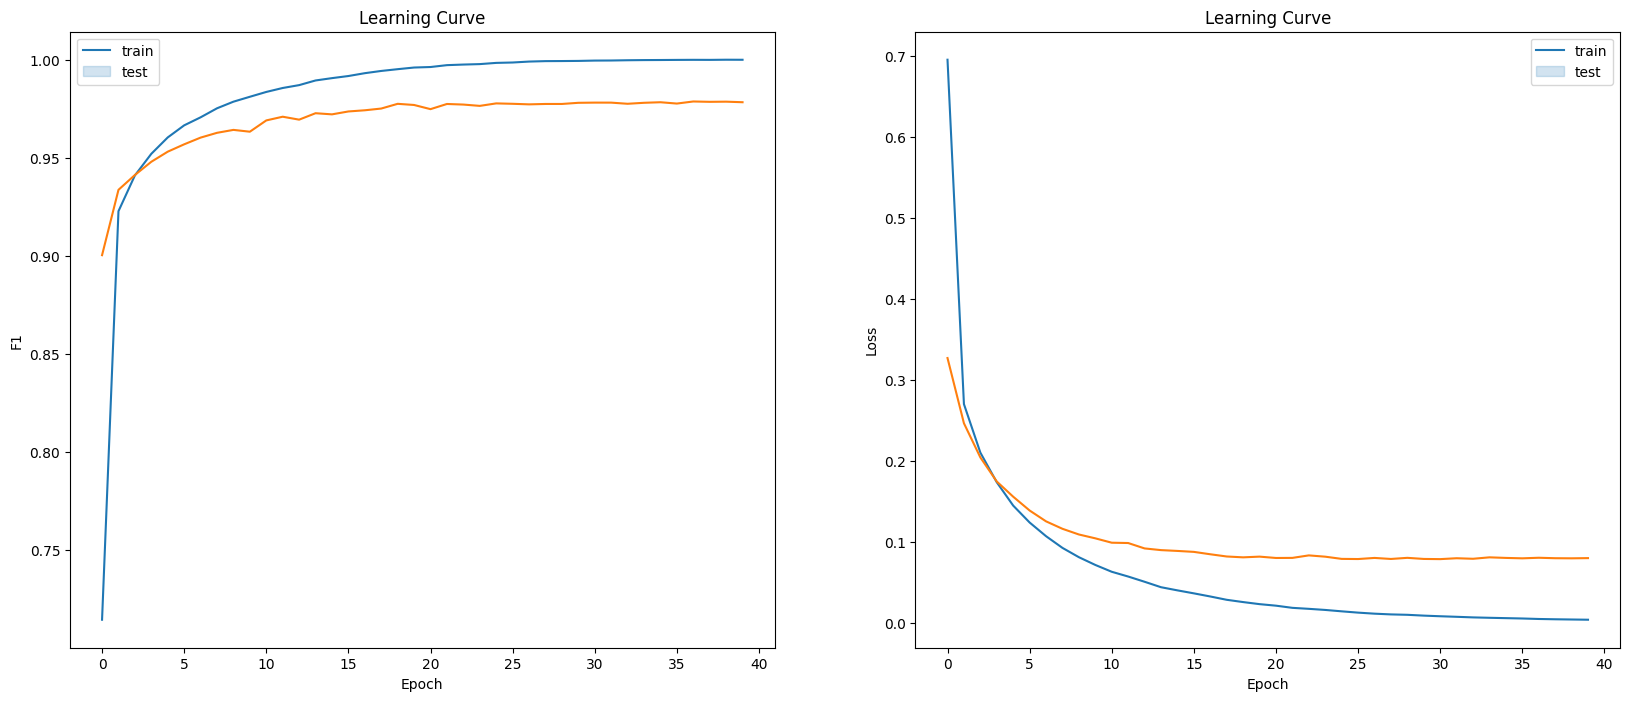

In [32]:
draw_learning_curve(learning_history)

In [33]:
def get_mlpv2():

    return Sequential([
        Dense(512, input_dim=num_pixels, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

In [34]:
model = get_mlpv2()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 567434 (2.16 MB)
Trainable params: 56743

In [35]:
learning_history = model.fit(X_train, y_train,
          batch_size = 1024, epochs = 40, verbose = 2, callbacks = callbacks('mlp_reg'),
          validation_data=(X_val, y_val));

Epoch 1/40
37/37 - 3s - loss: 0.8041 - f1: 0.6686 - val_loss: 0.2810 - val_f1: 0.9151 - lr: 0.0010 - 3s/epoch - 87ms/step
Epoch 2/40
37/37 - 0s - loss: 0.2553 - f1: 0.9256 - val_loss: 0.1780 - val_f1: 0.9385 - lr: 0.0010 - 289ms/epoch - 8ms/step
Epoch 3/40
37/37 - 0s - loss: 0.1765 - f1: 0.9470 - val_loss: 0.1360 - val_f1: 0.9528 - lr: 0.0010 - 304ms/epoch - 8ms/step
Epoch 4/40
37/37 - 0s - loss: 0.1331 - f1: 0.9601 - val_loss: 0.1132 - val_f1: 0.9612 - lr: 0.0010 - 287ms/epoch - 8ms/step
Epoch 5/40
37/37 - 0s - loss: 0.1095 - f1: 0.9671 - val_loss: 0.0958 - val_f1: 0.9661 - lr: 0.0010 - 399ms/epoch - 11ms/step
Epoch 6/40
37/37 - 0s - loss: 0.0870 - f1: 0.9735 - val_loss: 0.0894 - val_f1: 0.9727 - lr: 0.0010 - 429ms/epoch - 12ms/step
Epoch 7/40
37/37 - 0s - loss: 0.0753 - f1: 0.9771 - val_loss: 0.0787 - val_f1: 0.9778 - lr: 0.0010 - 365ms/epoch - 10ms/step
Epoch 8/40
37/37 - 0s - loss: 0.0616 - f1: 0.9807 - val_loss: 0.0753 - val_f1: 0.9784 - lr: 0.0010 - 405ms/epoch - 11ms/step
Epoch 

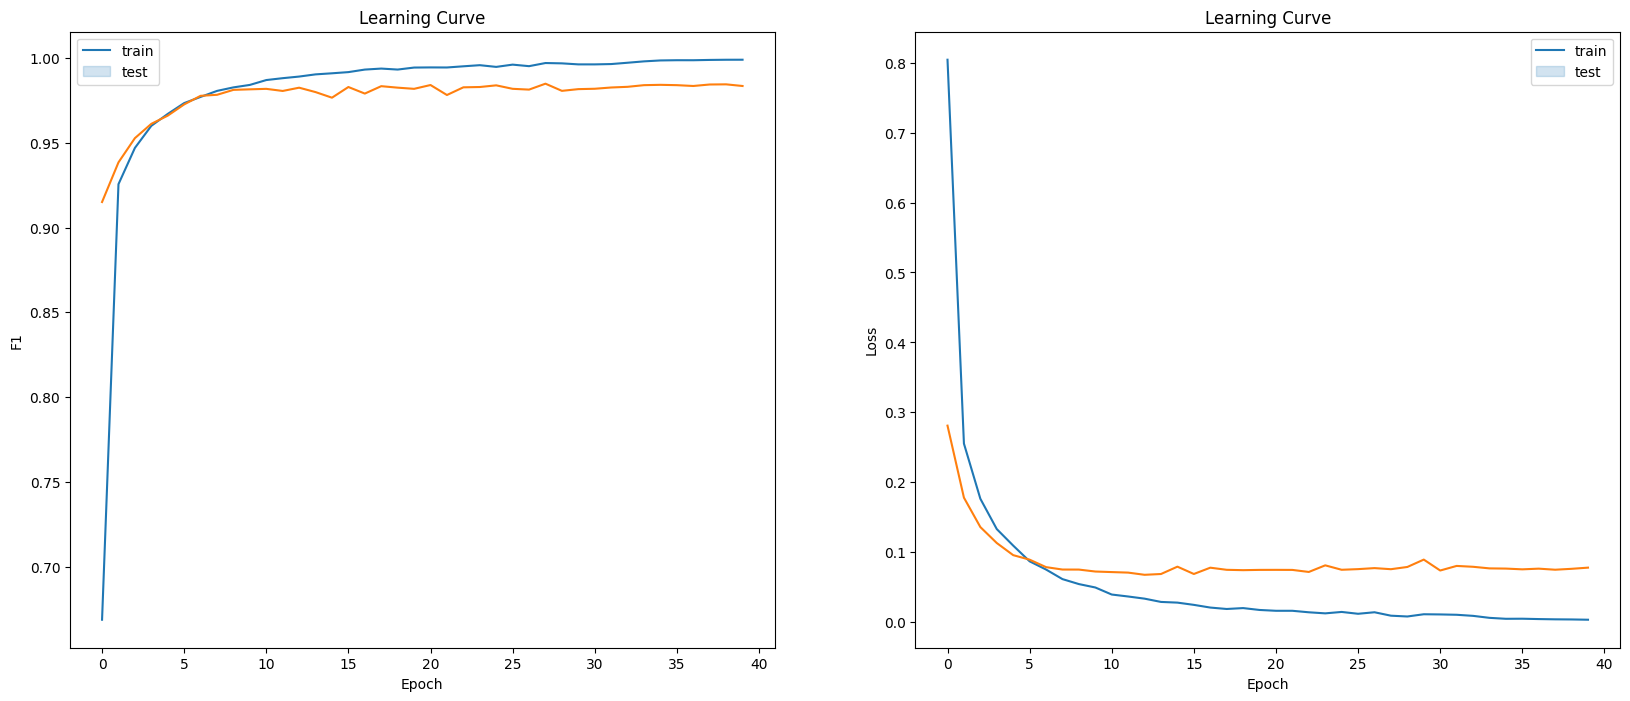

In [36]:
draw_learning_curve(learning_history)

In [37]:
score = model.evaluate(X_val, y_val, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test score: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 7.7967628836631775%
Test score: 98.00986051559448%
MLP Error: 1.99%


In [38]:
X_train.shape

(37800, 784)

In [39]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [40]:
def get_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu' ),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),


        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")

    ])

In [41]:
model = get_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                      

In [42]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 50,
          verbose = 1,
          callbacks = callbacks('cnn_v1'),
          validation_data = (X_val, y_val))

Epoch 1/50
296/296 [==============================] - 11s 15ms/step - loss: 0.5108 - f1: 0.8080 - val_loss: 0.0839 - val_f1: 0.9734 - lr: 0.0010
Epoch 2/50
296/296 [==============================] - 3s 12ms/step - loss: 0.1050 - f1: 0.9702 - val_loss: 0.0438 - val_f1: 0.9875 - lr: 0.0010
Epoch 3/50
296/296 [==============================] - 4s 12ms/step - loss: 0.0765 - f1: 0.9782 - val_loss: 0.0350 - val_f1: 0.9898 - lr: 0.0010
Epoch 4/50
296/296 [==============================] - 3s 12ms/step - loss: 0.0592 - f1: 0.9830 - val_loss: 0.0313 - val_f1: 0.9913 - lr: 0.0010
Epoch 5/50
296/296 [==============================] - 3s 11ms/step - loss: 0.0480 - f1: 0.9864 - val_loss: 0.0387 - val_f1: 0.9889 - lr: 0.0010
Epoch 6/50
296/296 [==============================] - 3s 12ms/step - loss: 0.0437 - f1: 0.9880 - val_loss: 0.0354 - val_f1: 0.9906 - lr: 0.0010
Epoch 7/50
296/296 [==============================] - 3s 11ms/step - loss: 0.0368 - f1: 0.9900 - val_loss: 0.0320 - val_f1: 0.9922 - lr

In [43]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.027734680101275444
Test score: 0.9949043989181519
CNN Error: 0.51%


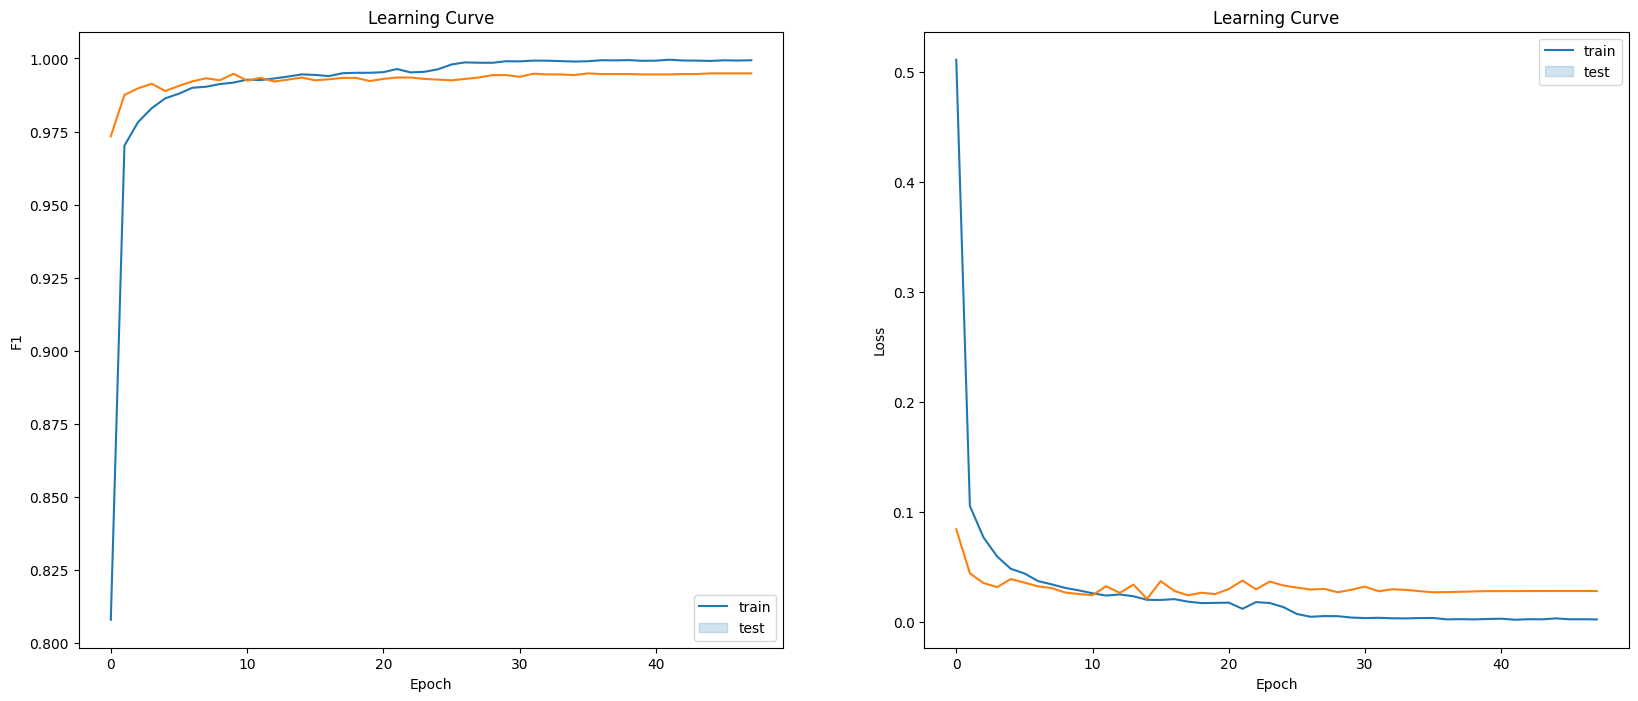

In [44]:
draw_learning_curve(learning_history)


In [45]:
y_pred = model.predict(X_val)


132/132 [==============================] - 1s 3ms/step


In [46]:
def draw_output(idx_nums):
    plt.figure(figsize = (20, 20))
    plt.xticks( range(10) )
    x = np.ceil(np.sqrt(len(idx_nums)))
    cnt = 1
    for ph in idx_nums:
        plt.subplot(x, x, cnt)
        curr_photo = y_val[ph]

        plt.xlim(0, 10)
        plt.title("Digit: {0}\n idx: {1} ".format(np.argmax(y_val[ph]), ph), fontsize = 10)
        plt.bar(range(10), y_pred[ph])

        cnt += 1

<ipython-input-48-4709add37c1c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=cnt_error[0], y=cnt_error[1], palette="muted")


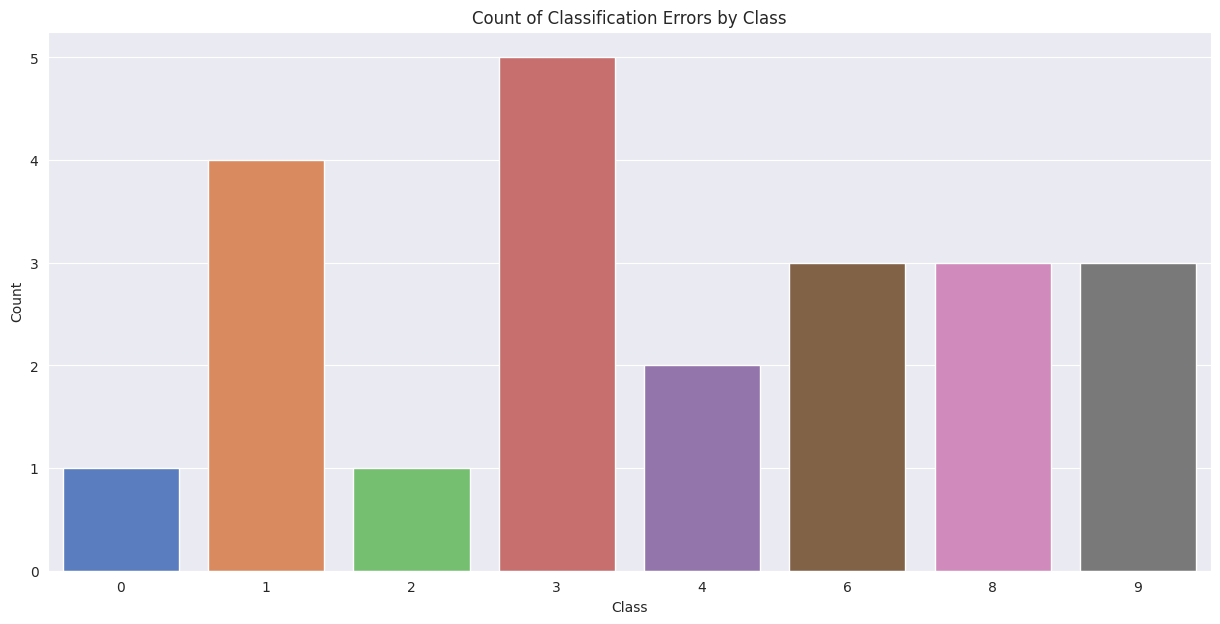

In [48]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    cnt_error.append(np.argmax(a))

cnt_error = np.unique(cnt_error, return_counts=True)
sns.set_style("darkgrid")
plt.figure(figsize=(15, 7))
bar_plot = sns.barplot(x=cnt_error[0], y=cnt_error[1], palette="muted")
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Classification Errors by Class')
plt.show()

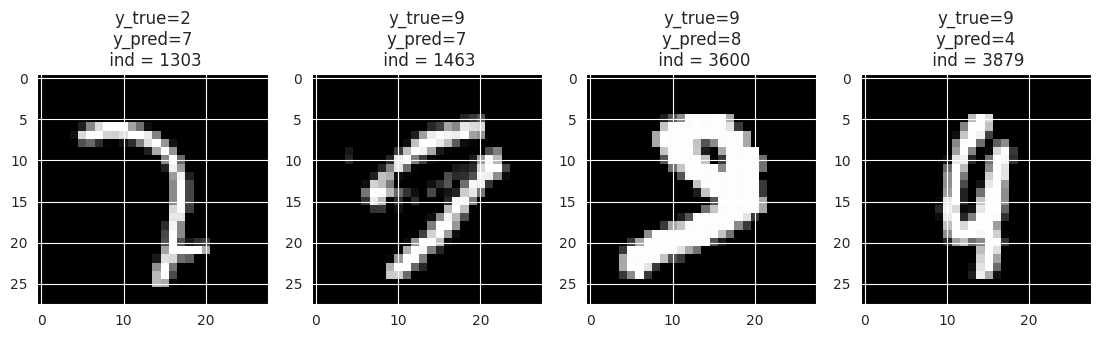

In [49]:
cnt_ind = 1
list_idx = []
X_val_plot = X_val.reshape( X_val.shape[:-1] )
fig = plt.figure(figsize=(14, 14))

for idx, (a, b) in enumerate(zip(y_val, y_pred)):
    if np.argmax(a) == np.argmax(b): continue
    if (np.argmax(a) == 2 or np.argmax(a) == 9):
        plt.subplot(5, 5, cnt_ind)
        plt.imshow(X_val_plot[idx], cmap='gray', interpolation='none')
        plt.title('y_true={0}\ny_pred={1}\n ind = {2}'.format(np.argmax(a), np.argmax(b), idx))
        plt.tight_layout()
        list_idx.append(idx)
        cnt_ind += 1

In [51]:
import matplotlib.gridspec as gridspec

In [53]:
def draw_output(list_idx):
    # Example code for gridspec
    nrows = 2  # Ensure nrows is an integer
    ncols = 1  # Ensure ncols is an integer

    fig = plt.figure()
    gs = gridspec.GridSpec(nrows, ncols)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(list_idx)  # Replace with actual plotting code
    plt.show()

In [54]:
train_aug = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False,
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        fill_mode = 'nearest',
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)


train_aug.fit(X_train)
train_gen = train_aug.flow(X_train, y_train, batch_size=64)

In [55]:
def get_cnn_v2():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),


        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(num_classes, activation = "softmax")

    ])

In [56]:
model = get_cnn_v2()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)       

In [58]:
learning_history = model.fit(train_gen, epochs = 100,
                               steps_per_epoch = X_train.shape[0] // 64,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks('best_cnn'),
                             )

Epoch 1/100
590/590 [==============================] - 16s 27ms/step - loss: 0.1702 - f1: 0.9513 - val_loss: 0.0454 - val_f1: 0.9859 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 18s 30ms/step - loss: 0.1267 - f1: 0.9639 - val_loss: 0.0429 - val_f1: 0.9848 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 17s 29ms/step - loss: 0.1026 - f1: 0.9715 - val_loss: 0.0395 - val_f1: 0.9895 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 17s 29ms/step - loss: 0.0882 - f1: 0.9752 - val_loss: 0.0462 - val_f1: 0.9873 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 18s 30ms/step - loss: 0.0862 - f1: 0.9767 - val_loss: 0.0349 - val_f1: 0.9909 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 17s 28ms/step - loss: 0.0722 - f1: 0.9795 - val_loss: 0.0294 - val_f1: 0.9922 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 16s 28ms/step - loss: 0.0712 - f1: 0.9804 - val_loss: 0.0486 - val_f1

In [59]:
model = load_model('../working/best_cnn.keras', custom_objects={"f1": f1})


In [60]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test score:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.012923866510391235
Test score: 0.9964488744735718
CNN Error: 0.36%


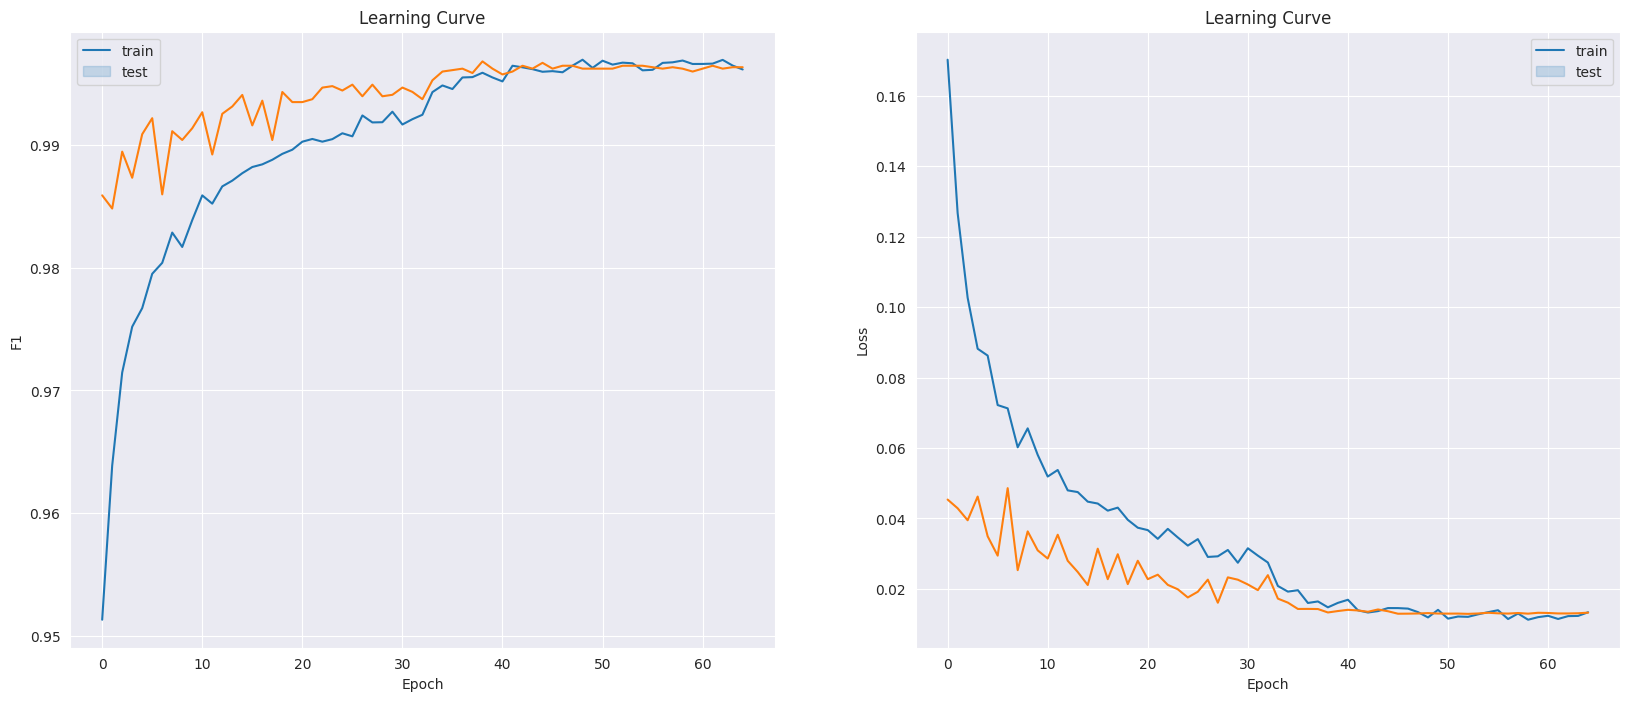

In [61]:
draw_learning_curve(learning_history)


In [62]:
output = model.predict(X_test)

output = np.argmax(output, axis = 1)

output = pd.Series(output, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), output], axis = 1)

submission.to_csv("submission.csv", index=False)

875/875 [==============================] - 4s 4ms/step
